<a href="https://colab.research.google.com/github/subhadrashaw/project/blob/main/AAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Lysarthas/Time-Transformer
%cd Time-Transformer


Cloning into 'Time-Transformer'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 104 (delta 21), reused 56 (delta 11), pack-reused 27
Receiving objects: 100% (104/104), 49.19 MiB | 30.47 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/Time-Transformer


In [ ]:
!pip install -r requirement.txt

  Using cached numpy-1.21.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.9 MB)
  Using cached tensorflow-2.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
  Using cached scikit-learn-0.24.2.tar.gz (7.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install scikit-learn


In [ ]:
pip install --upgrade pip

In [ ]:
!pip install torch==2.1.0

In [ ]:
!pip install fastapi kaleido python-multipart uvicorn

In [ ]:
!pip install scipy==1.11.4

In [ ]:
%run aae.py

In [ ]:
!pip install keras.utils

In [ ]:
%run tools.py

In [ ]:
%run networks.py

In [ ]:
%run evaluation_model.py

In [41]:
%run aae_trainer.py

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
%run tutorial.ipynb


In [43]:
from aae import aae_model
from tools import MinMaxScaler, DiscrMonitor
from evaluation_model import disc_eva, fore_eva
from networks import timesformer_dec, cnn_enc, cnn_dec, cautrans_dec, discriminator
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from sklearn.model_selection import train_test_split
import scipy.stats

**Prepare Data**

In [44]:
dataset = 'sine_cpx'            #use Sine_cpx as an example
valid_perc = 0.1
train_perc = 1-valid_perc
full_train_data = np.load('datasets/'+dataset+'.npy')
N, T, D = full_train_data.shape

In [45]:
N_train = int(N * (1 - valid_perc))
N_valid = N - N_train
np.random.shuffle(full_train_data)
train_data = full_train_data[:N_train]
valid_data = full_train_data[N_train:]
scaler = MinMaxScaler()
x_train = scaler.fit_transform(train_data)
x_valid = scaler.transform(valid_data)

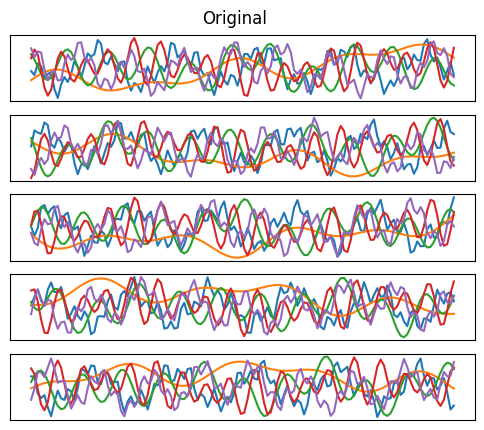

In [46]:
fig, axs = plt.subplots(5, 1, figsize=(6,5), sharex=True)
for i in range(5):
    rnd_idx = np.random.choice(len(x_train))
    s = x_train[rnd_idx]
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(s)
st = plt.suptitle('Original')
st.set_y(0.93)

**Build model**

In [47]:
ts_shape = x_train.shape[1:]
latent = 16

In [48]:
enc = cnn_enc(
    input_shape=ts_shape,
    latent_dim=latent,
    n_filters=[64, 128, 256],
    k_size=4,
    dropout=0.2
)

dec = timesformer_dec(
    input_shape=latent,
    ts_shape=ts_shape,
    head_size=64,
    num_heads=3,
    n_filters=[128, 64],
    k_size=4,
    dilations=[1,4],
    dropout=0.2
)

disc = discriminator(input_shape=latent, hidden_unit=32)

In [49]:
def ae_loss(ori_ts, rec_ts):
    return tf.keras.metrics.mse(ori_ts, rec_ts)

def dis_loss(y_true, y_pred):
    return tf.keras.metrics.binary_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=True)

def gen_loss(y_true, y_pred):
    return tf.keras.metrics.binary_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=True)

In [50]:
ae_schedule = PolynomialDecay(initial_learning_rate=0.005, decay_steps=300, end_learning_rate=0.0001, power=0.5)
dc_schedule = PolynomialDecay(initial_learning_rate=0.001, decay_steps=300, end_learning_rate=0.0001, power=0.5)
ge_schedule = PolynomialDecay(initial_learning_rate=0.001, decay_steps=300, end_learning_rate=0.0001, power=0.5)

In [51]:
ae_opt = tf.keras.optimizers.Adam(ae_schedule)
dc_opt = tf.keras.optimizers.Adam(dc_schedule)
ge_opt = tf.keras.optimizers.Adam(ge_schedule)

In [52]:
model = aae_model(
    encoder=enc,
    decoder=dec,
    discriminator=disc,
    latent_dim=latent,
    dis_steps=1,
    gen_steps=1)

In [53]:
model.compile(rec_opt=ae_opt, rec_obj=ae_loss, dis_opt=dc_opt, dis_obj=dis_loss, gen_opt=ge_opt, gen_obj=gen_loss)

**Train model**

We provide pre-trained model weights here, you are welcome to change the parameters and play with it.

In [54]:
model.load_weights('save_model/sine_cpx/aae_ckp') #pre_trained model, to reproduce similar results as paper

ValueError: You are trying to restore a checkpoint from a legacy Keras optimizer into a v2.11+ Optimizer, which can cause errors. Please update the optimizer referenced in your code to be an instance of `tf.keras.optimizers.legacy.Optimizer`, e.g.: `tf.keras.optimizers.legacy.Adam`.

In [ ]:
history = model.fit(x_train, epochs=800, batch_size=128) #you can train the model from the start here

Epoch 1/800


36/36 [==============================] - 138s 3s/step - rec_loss: 13.5725 - dis_loss: 1.7719 - gen_loss: 0.5626
Epoch 2/800
36/36 [==============================] - 108s 3s/step - rec_loss: 1.2161 - dis_loss: 1.1825 - gen_loss: 0.3474
Epoch 3/800
36/36 [==============================] - 104s 3s/step - rec_loss: 0.6836 - dis_loss: 1.0684 - gen_loss: 0.6399
Epoch 4/800
36/36 [==============================] - ETA: 0s - rec_loss: 0.5770 - dis_loss: 0.7951 - gen_loss: 0.8501

In [ ]:
z = tf.random.normal([x_train.shape[0], latent], 0.0, 1.0)
sample = model.dec.predict(z)

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(4,6), sharex=True)
for i in range(5):
    rnd_idx = np.random.choice(len(sample))
    s = sample[rnd_idx]
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(s)
st = plt.suptitle('Time-Transformer')
st.set_y(0.93)

**Visualization**

In [ ]:
train_ori = np.mean(x_train, axis=-1)
train_gen = np.mean(sample, axis=-1)

In [ ]:
select = x_train.shape[0]
idx = np.random.permutation(select)
ori = train_ori[idx]
gen = train_gen[idx]
prep_data_final = np.concatenate((ori, gen), axis = 0)

In [ ]:
emb = TSNE(n_components=2, learning_rate=10, init = 'random', perplexity=50, n_iter=400).fit_transform(prep_data_final)
plt.yticks([])
plt.xticks([])
plt.scatter(emb[:select, 0], emb[:select, 1], alpha=0.2, color='b')
plt.scatter(emb[select:, 0], emb[select:, 1], alpha=0.2, color='r')

**Discriminative Score**

In [ ]:
res_d = []
for _ in range(5):  # run 5 times to calculate avg and CI
    x_train_d = np.concatenate((x_train, sample))
    y_train_d = np.append(np.ones(x_train.shape[0]), np.zeros(sample.shape[0]))
    disc_m = disc_eva(input_shape=x_train_d.shape[1:], rnn_unit=[128], dropout=0.3)
    disc_m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    disc_m.fit(x_train_d, y_train_d, epochs=200, batch_size=128, verbose=0)

    test_gen = model.dec.predict(tf.random.normal([N_valid, latent], 0.0, 1.0))
    test_ori = x_valid
    x_test_d = np.concatenate((test_ori, test_gen))
    y_test_d = np.append(np.ones(test_ori.shape[0]), np.zeros(test_gen.shape[0]))
    l, acc = disc_m.evaluate(x_test_d, y_test_d)
    res_d.append(np.abs(acc-0.5))

print("Max:{}, Min:{}, Avg:{}".format(np.max(res_d), np.min(res_d), np.mean(res_d)))

In [ ]:
se = scipy.stats.sem(res_d)
se*scipy.stats.t.ppf((1 + 0.95) / 2., 5-1)

**Predictive Score**

In [ ]:
def forecast_data(x): #prepare forecast data
    x = x[:, :-1, :]
    y = x[:, -1, :]
    return x, y

In [ ]:
res = []
for _ in range(5): # run 5 times to calculate avg and CI
    x_train_p, y_train_p = forecast_data(sample) # Train on synthetic
    x_test, y_test = forecast_data(x_train) # Test on real
    fore = fore_eva(input_shape=x_train_p.shape[1:], out_shape=x_train_p.shape[-1], rnn_unit=[128])
    fore.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')
    fore.fit(x_train_p, y_train_p, epochs=200, batch_size=128, verbose=0)
    res.append(fore.evaluate(x_test, y_test))
print(np.max(res), np.min(res), np.mean(res))

In [ ]:
se = scipy.stats.sem(res)
se*scipy.stats.t.ppf((1 + 0.95) / 2., 5-1)

**Save generated data**

In [ ]:
np.save('save_model/gen_'+dataset+'.npy', sample)